# Test model for rigid body of colloid 

**Author:** HOOMD-blue, YeNguyenEdalgo

Simulation of colloid as a rigid body, addition of beads representing ligand on the surface of the colloid 

## Initialize

In [119]:
from __future__ import division
import hoomd
import hoomd.md

In [120]:
hoomd.context.initialize("");

## Parameters

In [121]:
change_seed = 5048

duplication       = [2, 2, 2]

NP_diameter       = 10
NP_mass           = 1.0
A_diameter        = 1

a_1 = a_2 = a_3 = 20

A_pos_1           = (5.5, 0, 0)
A_pos_2           = (6.5, 0, 0)
A_pos_3           = (7.5, 0, 0)
A_pos_4           = (-5.5, 0, 0)
A_pos_5           = (-6.5, 0, 0)
A_pos_6           = (-7.5, 0, 0)
A_pos_7           = (0, 0, -5.5)
A_pos_8           = (0, 0, -6.5)
A_pos_9           = (0, 0, -7.5)
A_pos_10          = (0, 0, 5.5)
A_pos_11          = (0, 0, 6.5)
A_pos_12          = (0, 0, 7.5)

lj_cutoff  = 2**(1/6)
lj_epsilon = 1.0 
lj_sigma   = 1.0 

step_size = 0.005
temperature = 1 
dipole_moment = 5
total_time_step = 1e4 
log_period = 100 

## Constructing unit cell 

In [122]:
uc = hoomd.lattice.unitcell(N = 1, 
                            a1 = [a_1, 0, 0],
                            a2 = [0, a_2, 0],
                            a3 = [0, 0, a_3], 
                            dimensions = 3,
                            type_name = ['NP'],
                            mass = [NP_mass],
                            moment_inertia = [[2/5*NP_mass*(NP_diameter/2+3*A_diameter)**2,
                                               2/5*NP_mass*(NP_diameter/2+3*A_diameter)**2,
                                               2/5*NP_mass*(NP_diameter/2+3*A_diameter)**2]],
                            diameter = [NP_diameter])

system = hoomd.init.create_lattice(uc, n=duplication)

notice(2): Group "all" created containing 8 particles


## Contructing the rigid body represent the nanoparticle core with constituents beads as ligand shell

In [123]:
system.particles.types.add('A')
#system.particles.types.add('B')

rigid = hoomd.md.constrain.rigid();
rigid.set_param('NP',
                types = 12*['A'],
                positions = [A_pos_1, A_pos_2, A_pos_3,
                             A_pos_4, A_pos_5, A_pos_6,
                             A_pos_7, A_pos_8, A_pos_9,
                             A_pos_10, A_pos_11, A_pos_12],
                diameters = 12*[A_diameter])

rigid.create_bodies()
rigid.validate_bodies()

snap = system.take_snapshot(all=True)

notice(2): constrain.rigid(): Creating 8 rigid bodies (adding 96 particles)


## Bonds constructing among beads 

In [124]:
snap = system.take_snapshot(all=True)

print(snap.box)

num_NP = 8
num_bonds = int(1/2*(snap.particles.N-num_NP))

#snap.bonds.resize((snap.particles.N-num_NP)*2/3)
snap.bonds.resize(num_bonds)

for j in range(0, num_bonds):
    snap.bonds.group[j] = [j+8, j+8+1]
    
snap.bonds.types = ['bondA']
snap.bonds.typeid[:] = 0

system.restore_snapshot(snap)

Box: Lx=40.0 Ly=40.0 Lz=40.0 xy=0.0 xz=0.0 yz=0.0 dimensions=3


104
tag         : 0
position    : (-10.0, -10.0, -10.0)
image       : (0, 0, 0)
velocity    : (0.0, 0.0, 0.0)
acceleration: (0.0, 0.0, 0.0)
charge      : 0.0
mass        : 1.0
diameter    : 10.0
type        : NP
typeid      : 0
body        : 0
orientation : (1.0, 0.0, 0.0, 0.0)
mom. inertia: (25.600000381469727, 25.600000381469727, 25.600000381469727)
angular_momentum: (0.0, 0.0, 0.0, 0.0)
net_force   : (0.0, 0.0, 0.0)
net_energy  : 0.0
net_torque  : (0.0, 0.0, 0.0)
net_virial  : (0.0, 0.0, 0.0, 0.0, 0.0, 0.0)

tag         : 1
position    : (-10.0, -10.0, 10.0)
image       : (0, 0, 0)
velocity    : (0.0, 0.0, 0.0)
acceleration: (0.0, 0.0, 0.0)
charge      : 0.0
mass        : 1.0
diameter    : 10.0
type        : NP
typeid      : 0
body        : 1
orientation : (1.0, 0.0, 0.0, 0.0)
mom. inertia: (25.600000381469727, 25.600000381469727, 25.600000381469727)
angular_momentum: (0.0, 0.0, 0.0, 0.0)
net_force   : (0.0, 0.0, 0.0)
net_energy  : 0.0
net_torque  : (0.0, 0.0, 0.0)
net_virial  : (0.

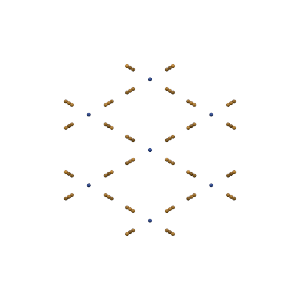

In [125]:
print(snap.particles.N)
for i in range(0,snap.particles.N): 
    print(system.particles[i])

print(snap.bonds.typeid)

for j in range(0, snap.bonds.N):
    print(system.bonds[j])
    
import ex_render
ex_render.render_sphere_frame(system.take_snapshot())

## Define the potential energy

### Harmonic bond potential

In [126]:
harmonicA = hoomd.md.bond.harmonic()
harmonicA.bond_coeff.set('bondA', k=1, r0=1)
harmonicA.bond_coeff.set('bondA_1', k=1, r0=1)

### LJ pair potential 

In [127]:
nl = hoomd.md.nlist.cell();
lj = hoomd.md.pair.lj(r_cut = lj_cutoff, nlist=nl)
lj.set_params(mode='shift')
lj.pair_coeff.set(['NP', 'A'], ['NP', 'A'], epsilon=lj_epsilon, sigma=lj_sigma)

## Select Integrator 

In [128]:
hoomd.md.integrate.mode_standard(dt=step_size);
rigid = hoomd.group.rigid_center()
hoomd.md.integrate.langevin(group=rigid, kT = temperature, seed=change_seed)

notice(2): Group "rigid_center" created containing 8 particles
notice(2): integrate.langevin/bd is using specified gamma values


## Write outputs and run simulaiton 

In [129]:
hoomd.analyze.log(filename="log-output_rigid.log",
                  quantities=['potential_energy', 'temperature'],
                  period=log_period,
                  overwrite=True);

hoomd.dump.gsd("trajectory_rigid.gsd", period=2e3, group=hoomd.group.all(), overwrite=True);

In [130]:
hoomd.run(total_time_step)

notice(2): -- Neighborlist exclusion statistics -- :
notice(2): Particles with 0 exclusions             : 55
notice(2): Particles with 1 exclusions             : 2
notice(2): Particles with 2 exclusions             : 47
notice(2): Neighbors included by diameter          : no
notice(2): Neighbors excluded when in the same body: yes
** starting run **
Time 00:00:02 | Step 10000 / 10000 | TPS 5973.51 | ETA 00:00:00
Average TPS: 5968.25
---------
-- Neighborlist stats:
1467 normal updates / 100 forced updates / 0 dangerous updates
n_neigh_min: 0 / n_neigh_max: 1 / n_neigh_avg: 0.00961538
shortest rebuild period: 2
-- Cell list stats:
Dimension: 26, 26, 26
n_min    : 0 / n_max: 2 / n_avg: 0.00591716
** run complete **


## Output analysis 

In [131]:
import numpy as np
from matplotlib import pyplot as plt 
%matplotlib inline

data = np.genfromtxt(fname="log-output_rigid.log", skip_header=True);

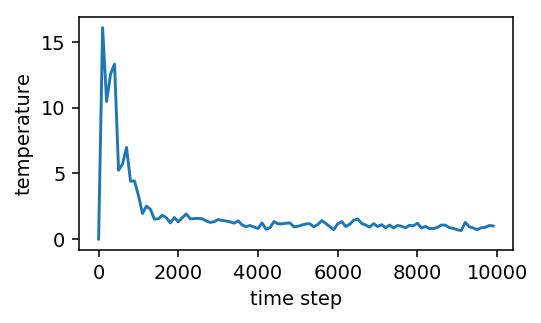

In [132]:
plt.figure(figsize=(4,2.2), dpi=140);
plt.plot(data[:,0], data[:,2]);
plt.xlabel('time step');
plt.ylabel('temperature');

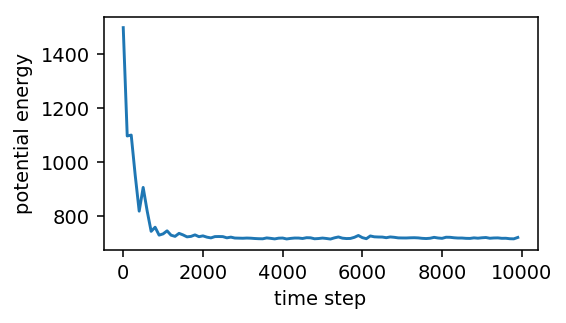

In [133]:
plt.figure(figsize=(4,2.2), dpi=140);
plt.plot(data[:,0], data[:,1]);
plt.xlabel('time step');
plt.ylabel('potential energy');

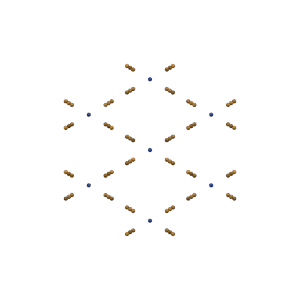

In [134]:
import ex_render
ex_render.display_movie(ex_render.render_sphere_frame, 'trajectory_rigid.gsd');